-----------------------------------------------------------------------------
                             Python Script
-----------------------------------------------------------------------------
Author: Dr. Hyunglok Kim
Affiliation: School of Earth Sciences and Environmental Engineering,
             Gwangju Institute of Science and Technology (GIST)

Date: 2023

Version: 1.0

Course: EN5422/EV4238 - Applied Machine Learning for Environmental Data Analysis

-----------------------------------------------------------------------------
                            COPYRIGHT NOTICE
-----------------------------------------------------------------------------
© 2023 Dr. Hyunglok Kim, Gwangju Institute of Science and Technology.
All Rights Reserved.

Permission is granted to any individual or institution to use, copy, or
redistribute this software and documentation, under the following
conditions:

1. The software and documentation must not be distributed for profit,
   and must retain this copyright notice.

2. Any modifications to the software must be documented and those
   modifications must be released under the same terms as this license.

3. This software and documentation is provided "as is". The author(s)
   disclaim all warranties, whether express or implied, including but
   not limited to implied warranties of merchantability and fitness
   for a particular purpose.

-----------------------------------------------------------------------------
                               DESCRIPTION
-----------------------------------------------------------------------------
This script is written as part of the teaching materials for the
EN5422/EV4238 course "Applied Machine Learning for Environmental Data Analysis"
at Gwangju Institute of Science and Technology (GIST).

For detailed usage, please refer to the accompanying documentation
or course materials.

For questions, feedback, or further information, please contact:

Dr. Hyunglok Kim
Email: hyunglokkim@gist.ac.kr

# Prostate Cancer (ESL notebook)
The data for this example come from a study by Stamey et al. (1989) that examined the correlation between the level of prostate specific antigen (PSA) and a number of clinical measures, in 97 men who were about to receive a radical prostatectomy.
The goal is to predict the log of PSA (lpsa) from a number of measurements.

Variables:

|         |                                                       |
|---------|-------------------------------------------------------|
|lpsa     |log prostate specific antigen                          |
|lcavol   |log cancer volume                                      |
|lweight  |log prostate weight                                    |
|age      |age                                                    |
|lbph     |log of benign prostatic hyperplasia amount             |
|svi      |seminal vesicle invasion                               |
|lcp      |log of capsular penetration                            |
|gleason  |Gleason score                                          |
|pgg45    |percent of Gleason scores 4 or 5                       |

This is a supervised learning problem, known as a regression problem, because the outcome measurement is quantitative.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Union, List
import warnings
%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
ORANGE, BLUE, PURPLE = '#E69F00', '#56B4E9', '#A020F0'
GRAY1, GRAY4 = '#231F20', '#646369'

# turn off numpy warings
np.warnings.filterwarnings('ignore')

## Load and Prepare Data

In [ ]:
# we will predict lpsa (log prostate specific antigen)
target = 'lpsa'
# based on the following features
features = ['lcavol', 'lweight', 'age', 'lbph',
            'svi', 'lcp', 'gleason', 'pgg45']
# load training and test data from the file

url = "https://raw.githubusercontent.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/1e2db4997082d00435d8cd006be7b0bcff5f0b5f/data/Prostate%20Cancer.txt"
df = pd.read_csv(url, delimiter=",")  # Assuming the file is tab-separated; adjust the delimiter as needed

df.head()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


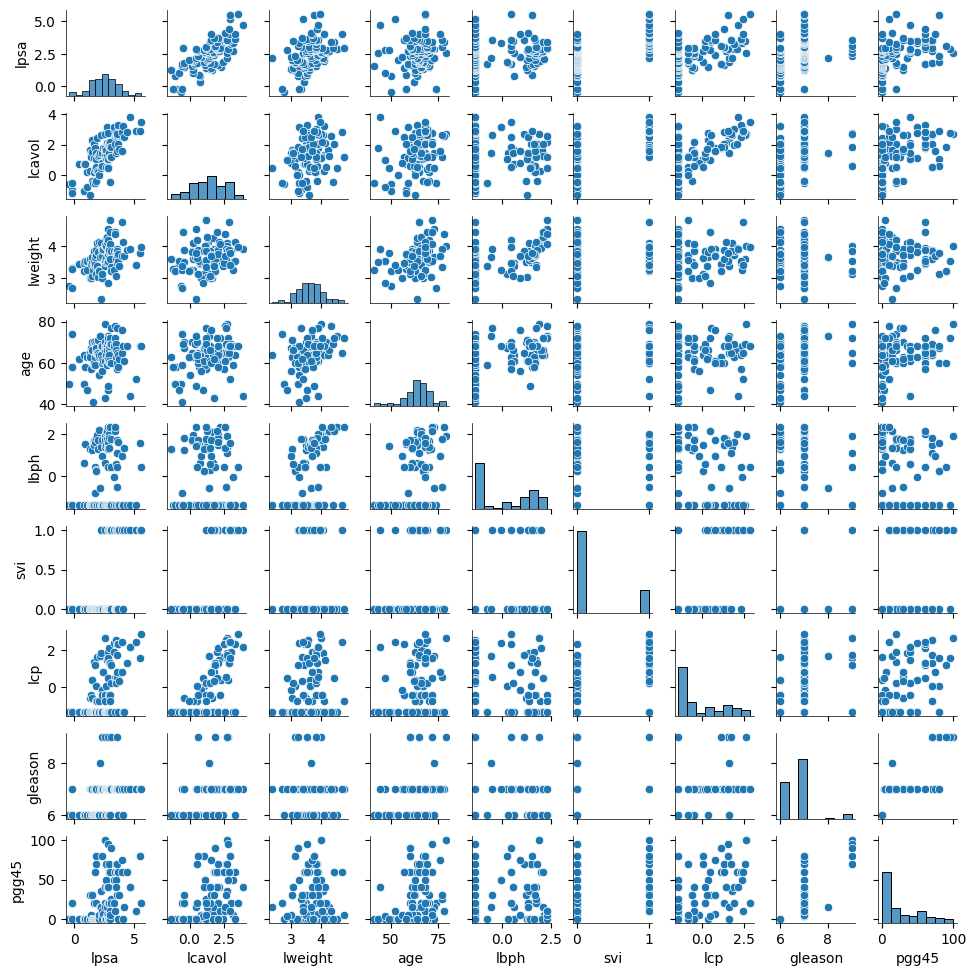

In [ ]:
sns.pairplot(df, vars=[target]+features, kind="scatter", height=1.1)

In [ ]:
# we will predict sales (log prostate specific antigen)
target_ad = 'sales'
# based on the following features
features_ad = ['TV', 'radio', 'newspaper']
# load training and test data from the file

url = "https://raw.githubusercontent.com/hardikkamboj/An-Introduction-to-Statistical-Learning/d891284abad8c95f84d9a62dc352f261ca3375b1/data/Advertising.csv"
df_ad = pd.read_csv(url)  # Assuming the file is tab-separated; adjust the delimiter as needed

df_ad.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


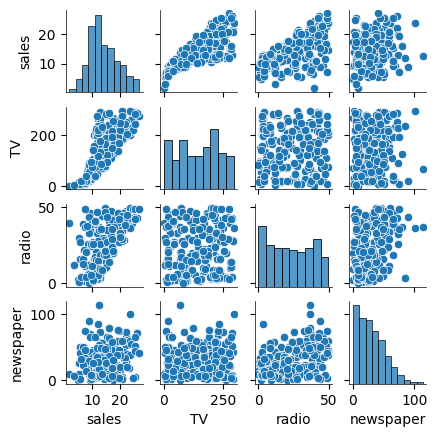

In [ ]:
sns.pairplot(df_ad, vars=[target_ad]+features_ad, kind="scatter", height=1.1)

To perform the best subsets method, we'll follow these steps:

    1. Create all possible combinations of features for each value of kk from 1 to 8.
    2. Train a linear regression model on each subset and calculate the Mean Squared Error (MSE).
    3. Plot the MSE values for each combination, and highlight the best (lowest) MSE for each kk in red.

We'll do this for both training and test data. Let's go step by step:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Step 1: First, we need to load required libraries and split the data:
# Load the dataset
target = 'lpsa'
features = ['lcavol', 'lweight', 'age', 'lbph',
            'svi', 'lcp', 'gleason', 'pgg45']
url = "https://raw.githubusercontent.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/1e2db4997082d00435d8cd006be7b0bcff5f0b5f/data/Prostate%20Cancer.txt"
df = pd.read_csv(url, delimiter=",")  # Assuming the file is tab-separated; adjust the delimiter as needed

# Split the data
train_df, test_df = train_test_split(df, test_size=0.30, random_state=42)

In [ ]:
# Step 2: Define a function to get the best subset for a given kk and another function to plot the MSEs:
def get_best_subset(train, test, k, target, features):
    """
    For a given k, find the combination of features that gives the smallest MSE on the training data.
    Also, evaluate each subset's MSE on test data.
    """
    train_mse_list = []
    test_mse_list = []
    subsets = list(combinations(features, k))
    for subset in subsets:
        # Training data
        X_train = train[list(subset)]
        y_train = train[target]
        model = LinearRegression().fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        train_mse_list.append(mean_squared_error(y_train, y_train_pred))

        # Test data
        X_test = test[list(subset)]
        y_test = test[target]
        y_test_pred = model.predict(X_test)
        test_mse_list.append(mean_squared_error(y_test, y_test_pred))

    return subsets, train_mse_list, test_mse_list


def plot_best_subsets(train, test, k_range, target, features):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # For training data
    best_train_mse_for_k = []
    for k in k_range:
        subsets, train_mse_list, _ = get_best_subset(train, test, k, target, features)
        best_train_mse_for_k.append(min(train_mse_list))
        axes[0].scatter([k]*len(train_mse_list), train_mse_list, facecolors='none', edgecolors='b', s=50)
        axes[0].scatter(k, min(train_mse_list), color='red', s=50)

    axes[0].plot(k_range, best_train_mse_for_k, color='red', marker='o')
    axes[0].set_title("Training Data")
    axes[0].set_xlabel('Number of Features (k)')
    axes[0].set_ylabel('Mean Squared Error (MSE)')

    # For test data
    best_test_mse_for_k = []
    for k in k_range:
        subsets, _, test_mse_list = get_best_subset(train, test, k, target, features)
        best_test_mse_for_k.append(min(test_mse_list))
        axes[1].scatter([k]*len(test_mse_list), test_mse_list, facecolors='none', edgecolors='b', s=50)
        axes[1].scatter(k, min(test_mse_list), color='red', s=50)

    axes[1].plot(k_range, best_test_mse_for_k, color='red', marker='o')
    axes[1].set_title("Test Data")
    axes[1].set_xlabel('Number of Features (k)')
    axes[1].set_ylabel('Mean Squared Error (MSE)')

    plt.tight_layout()
    plt.show()


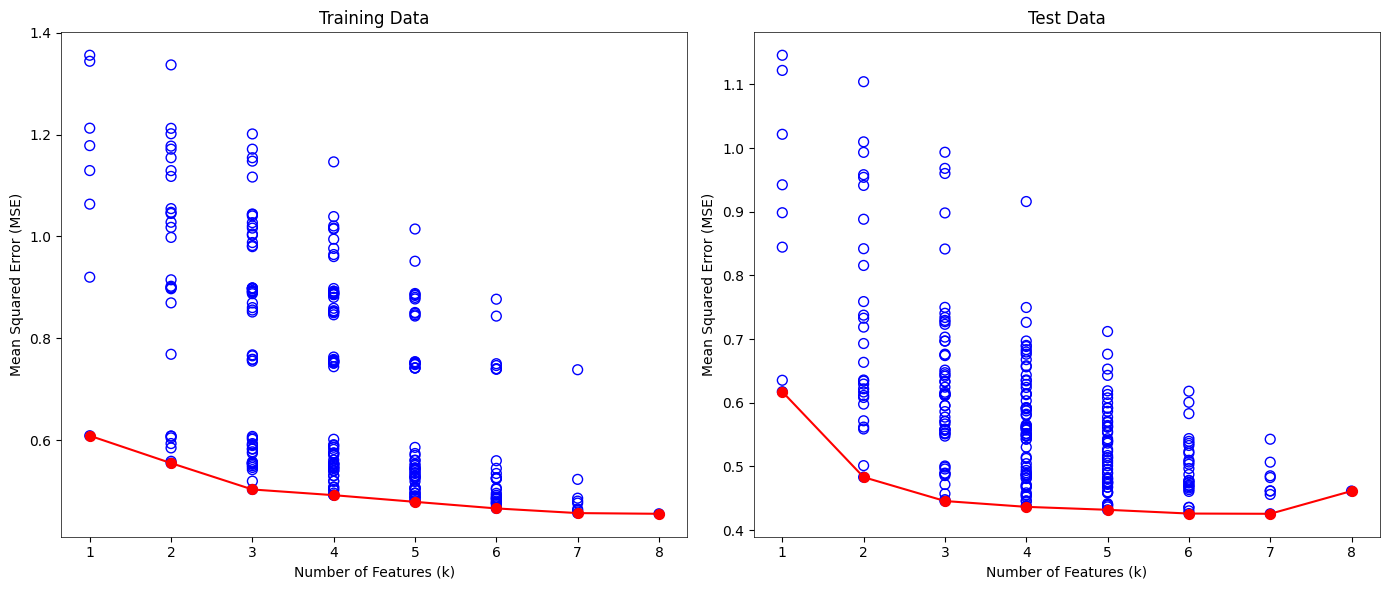

In [ ]:
# Step 3: Call the plotting function with the training and test data:
plot_best_subsets(train_df, test_df, range(1, 9), target, features)

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
url = "https://raw.githubusercontent.com/hardikkamboj/An-Introduction-to-Statistical-Learning/d891284abad8c95f84d9a62dc352f261ca3375b1/data/Advertising.csv"
df_ad = pd.read_csv(url)

# Prepare the data for regression
X = df_ad[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)  # Add an intercept (constant) to our model
y = df_ad['sales']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Extract the table similar to broom's tidy()
summary_table = pd.DataFrame({
    'term': model.params.index,
    'estimate': model.params.values,
    'std.error': model.bse.values,
    'statistic': model.tvalues.values,
    'p.value': model.pvalues.values
})

summary_table


,term,estimate,std.error,statistic,p.value
0,const,2.938889,0.311908,9.422288,1.267295e-17
1,TV,0.045765,0.001395,32.808624,1.509960e-81
2,radio,0.188530,0.008611,21.893496,1.505339e-54
3,newspaper,-0.001037,0.005871,-0.176715,8.599151e-01


In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
url = "https://raw.githubusercontent.com/hardikkamboj/An-Introduction-to-Statistical-Learning/d891284abad8c95f84d9a62dc352f261ca3375b1/data/Advertising.csv"
df_ad = pd.read_csv(url)

# Scale the newspaper column
df_ad['newspaper_scaled'] = df_ad['newspaper'] / 1000

# Prepare data for regression
X = df_ad[['TV', 'radio', 'newspaper_scaled']]
X = sm.add_constant(X)  # Add an intercept (constant) to our model
y = df_ad['sales']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Extract the table similar to broom's tidy()
summary_table = pd.DataFrame({
    'term': model.params.index,
    'estimate': model.params.values,
    'std.error': model.bse.values,
    'statistic': model.tvalues.values,
    'p.value': model.pvalues.values
})

summary_table


,term,estimate,std.error,statistic,p.value
0,const,2.938889,0.311908,9.422288,1.267295e-17
1,TV,0.045765,0.001395,32.808624,1.509960e-81
2,radio,0.188530,0.008611,21.893496,1.505339e-54
3,newspaper_scaled,-1.037493,5.871010,-0.176715,8.599151e-01


In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
url = "https://raw.githubusercontent.com/hardikkamboj/An-Introduction-to-Statistical-Learning/d891284abad8c95f84d9a62dc352f261ca3375b1/data/Advertising.csv"
df_ad = pd.read_csv(url)

# Calculate standard deviation for all columns
standard_deviations = df_ad.std()

# Print standard deviations (just to match the R output shown)
standard_deviations

Unnamed: 0    57.879185
TV            85.854236
radio         14.846809
newspaper     21.778621
sales          5.217457
dtype: float64

In [ ]:

# Scale the predictors
df_ad_scaled = df_ad.copy()
df_ad_scaled[['TV', 'radio', 'newspaper']] = df_ad[['TV', 'radio', 'newspaper']].div(standard_deviations[['TV', 'radio', 'newspaper']], axis=1)

# Prepare data for regression
X = df_ad_scaled[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)  # Add an intercept (constant) to our model
y = df_ad['sales']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Extract the table similar to broom's tidy()
summary_table = pd.DataFrame({
    'term': model.params.index,
    'estimate': model.params.values,
    'std.error': model.bse.values,
    'statistic': model.tvalues.values,
    'p.value': model.pvalues.values
})

summary_table

,term,estimate,std.error,statistic,p.value
0,const,2.938889,0.311908,9.422288,1.267295e-17
1,TV,3.929089,0.119758,32.808624,1.509960e-81
2,radio,2.799069,0.127849,21.893496,1.505339e-54
3,newspaper,-0.022595,0.127862,-0.176715,8.599151e-01


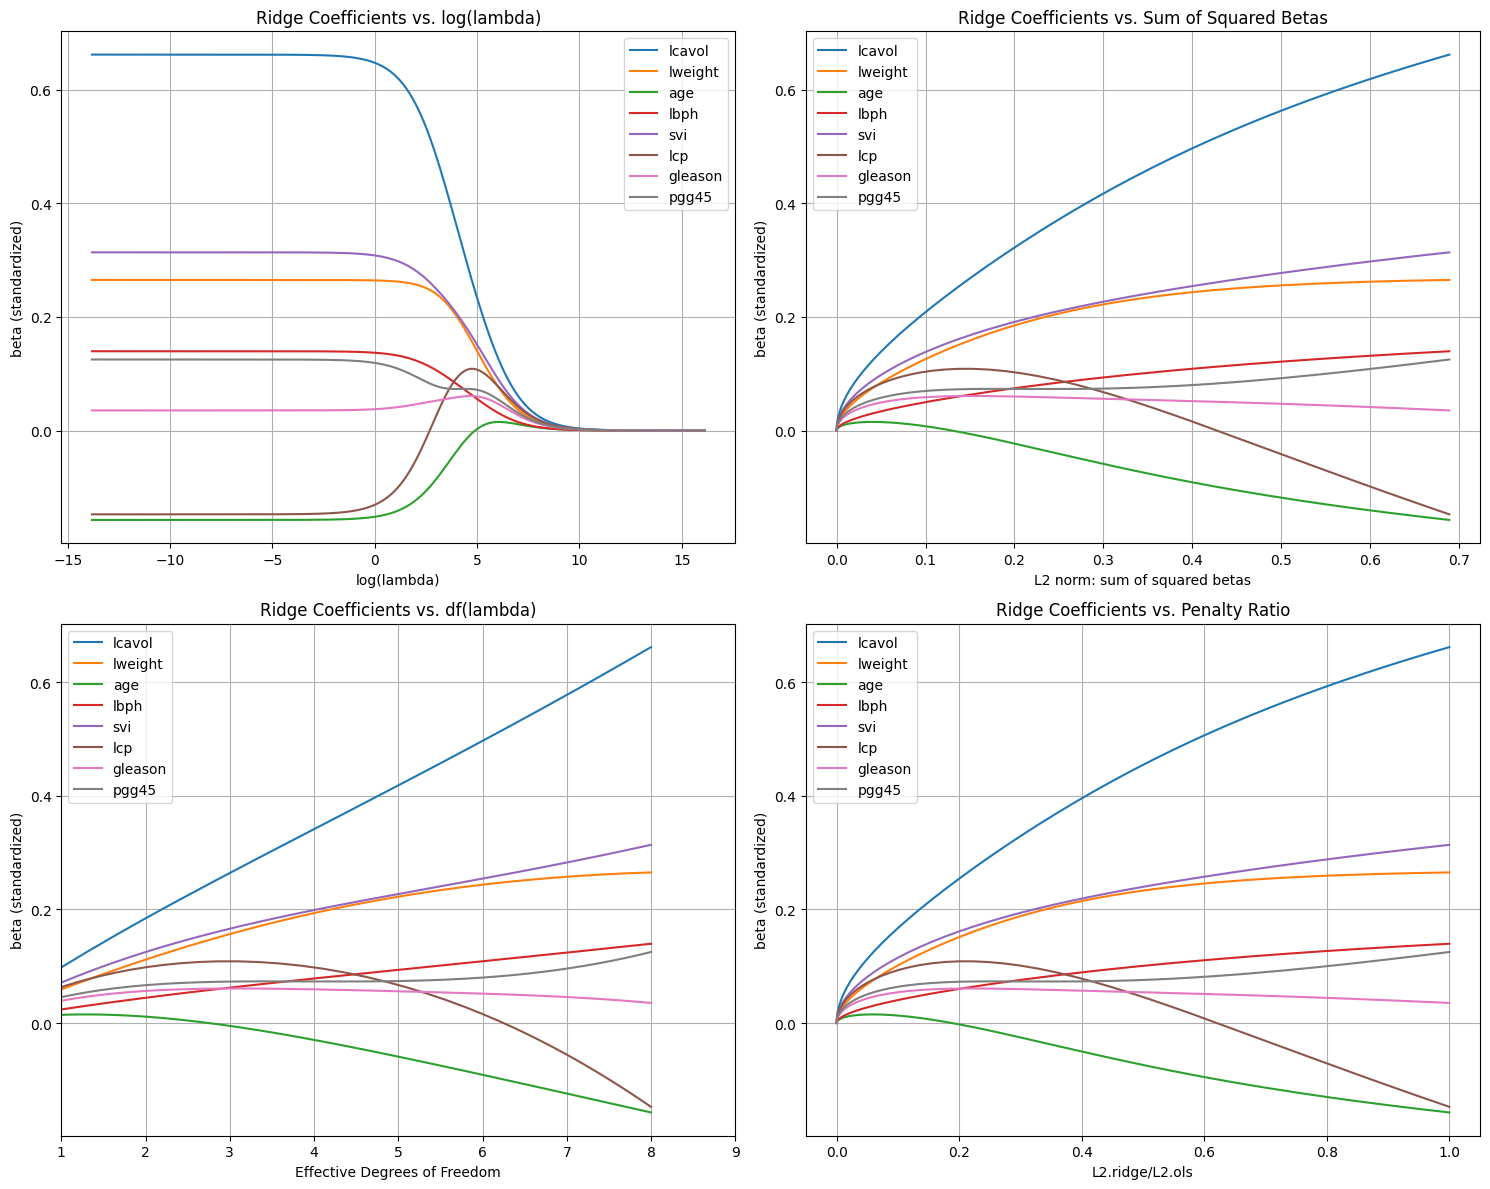

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[target]

# Generate a sequence of lambda values (alphas for Ridge in sklearn)
alphas = np.logspace(-6, 7, 200)

# Fit Ridge regression for each alpha and store coefficients
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Calculate the effective degrees of freedom for each alpha
dfs = [np.trace(X @ np.linalg.inv(X.T @ X + a * np.eye(X.shape[1])) @ X.T) for a in alphas]

# Plotting using subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# a. Coefficients vs log(lambda)
for i, feature in enumerate(features):
    axes[0, 0].plot(np.log(alphas), coefs[:, i], label=feature)
axes[0, 0].set_xlabel('log(lambda)')
axes[0, 0].set_ylabel('beta (standardized)')
axes[0, 0].set_title('Ridge Coefficients vs. log(lambda)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# b. Coefficients vs sum of squared betas
for i, feature in enumerate(features):
    axes[0, 1].plot(np.sum(coefs**2, axis=1), coefs[:, i], label=feature)
axes[0, 1].set_xlabel('L2 norm: sum of squared betas')
axes[0, 1].set_ylabel('beta (standardized)')
axes[0, 1].set_title('Ridge Coefficients vs. Sum of Squared Betas')
axes[0, 1].legend()
axes[0, 1].grid(True)

# c. Coefficients vs df(lambda)
for i, feature in enumerate(features):
    axes[1, 0].plot(dfs, coefs[:, i], label=feature)
axes[1, 0].set_xlabel('Effective Degrees of Freedom')
axes[1, 0].set_ylabel('beta (standardized)')
axes[1, 0].set_xlim(1, 9)
axes[1, 0].set_title('Ridge Coefficients vs. df(lambda)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# d. Ratio of ridge penalty to penalty at OLS solution
penalty_ratio = np.sum(coefs**2, axis=1) / np.sum(coefs[0, :]**2)
for i, feature in enumerate(features):
    axes[1, 1].plot(penalty_ratio, coefs[:, i], label=feature)
axes[1, 1].set_xlabel('L2.ridge/L2.ols')
axes[1, 1].set_ylabel('beta (standardized)')
axes[1, 1].set_title('Ridge Coefficients vs. Penalty Ratio')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Sample data
x = np.array([1, 2])
y = np.array([3, 4])

# Design matrix with an added intercept term
X = np.column_stack([np.ones(x.shape), x])

# Compute the hat matrix
H = X @ np.linalg.inv(X.T @ X) @ X.T

# Get the trace of the hat matrix
trace_H = np.trace(H)

print("Hat matrix H:")
print(H)
print("\nTrace of Hat matrix:", trace_H)

Hat matrix H:
[[1. 0.]
 [0. 1.]]

Trace of Hat matrix: 2.0000000000000018


In [ ]:
import numpy as np

# Sample data
x = np.array([1, 2, 3])
y = np.array([3, 4, 5])

# Design matrix with an added intercept term
X = np.column_stack([np.ones(x.shape), x])

# Regularization parameter for ridge regression
lambda_value = 1

# Compute the hat matrix for ridge regression
H_ridge = X @ np.linalg.inv(X.T @ X + lambda_value * np.eye(X.shape[1])) @ X.T

# Get the trace of the hat matrix
trace_H_ridge = np.trace(H_ridge)

print("Hat matrix H for Ridge Regression:")
print(H_ridge)
print("\nTrace of Hat matrix for Ridge Regression:", trace_H_ridge)

Hat matrix H for Ridge Regression:
[[0.29166667 0.20833333 0.125     ]
 [0.20833333 0.29166667 0.375     ]
 [0.125      0.375      0.625     ]]

Trace of Hat matrix for Ridge Regression: 1.208333333333333


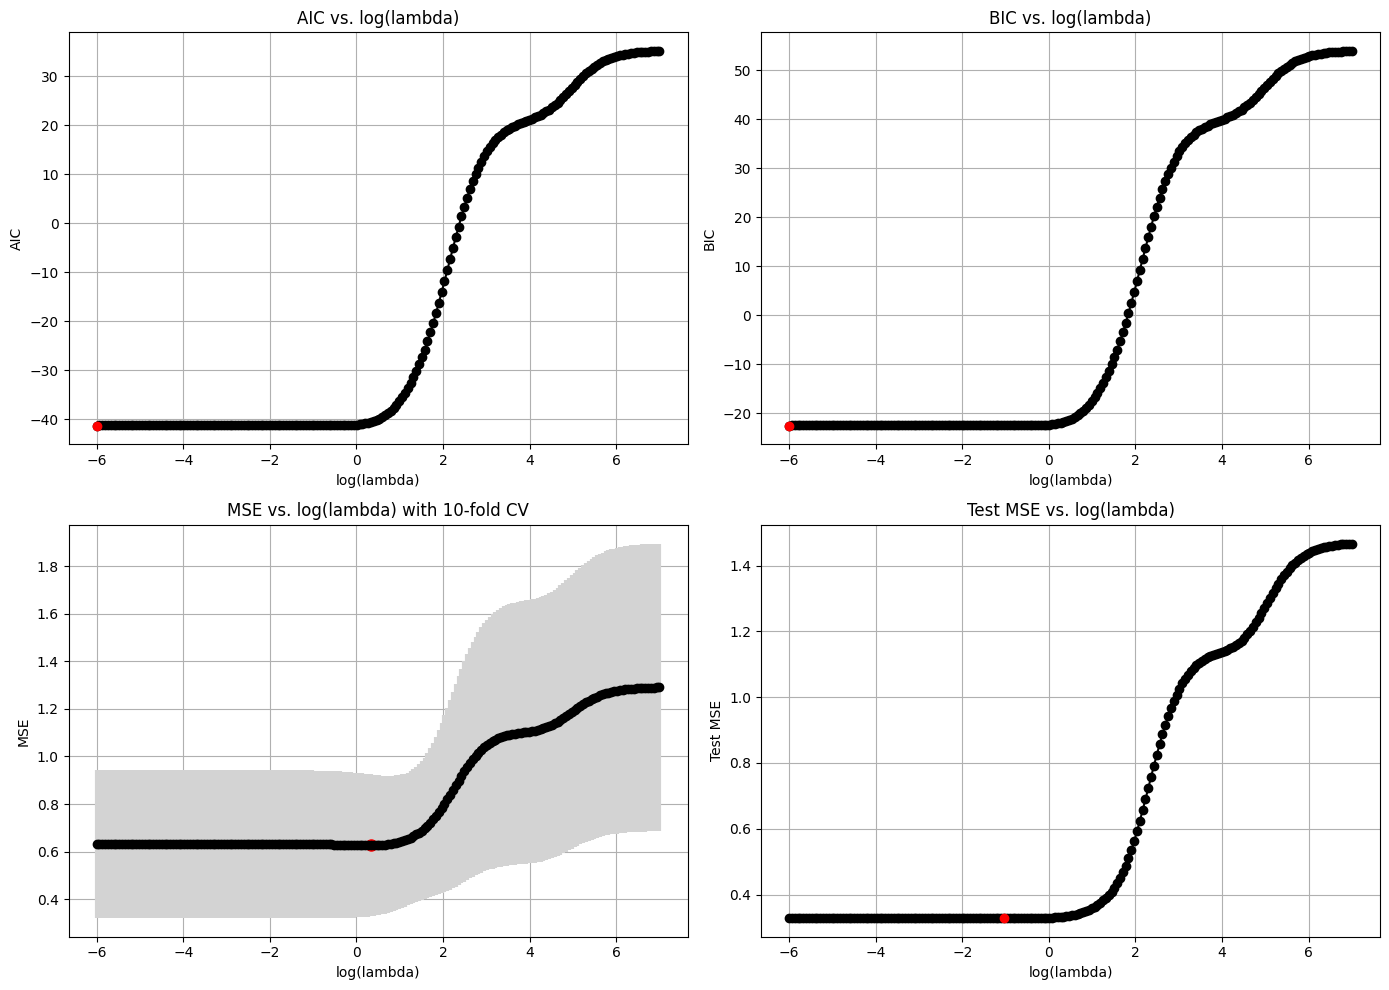

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
url = "https://raw.githubusercontent.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/1e2db4997082d00435d8cd006be7b0bcff5f0b5f/data/Prostate%20Cancer.txt"
df = pd.read_csv(url, delimiter=",")

# Split the dataset into features and target
X = df[features].values
y = df[target].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up lambda values and other parameters
lambdas = np.logspace(-6, 7, 200)
log_lambdas = np.log10(lambdas)
n = X_train.shape[0]
p = X_train.shape[1]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store metrics
aic_list = []
bic_list = []
mse_cv_mean = []
mse_cv_std = []
mse_test = []

for lamb in lambdas:
    ridge = Ridge(alpha=lamb)

    # AIC and BIC
    ridge.fit(X_train, y_train)
    residuals = y_train - ridge.predict(X_train)
    rss = np.sum(residuals**2)
    aic = n * np.log(rss/n) + 2 * p
    bic = n * np.log(rss/n) + np.log(n) * p
    aic_list.append(aic)
    bic_list.append(bic)

    # MSE with 10-fold CV
    mse_values = []
    for train_index, val_index in kf.split(X_train):
        ridge.fit(X_train[train_index], y_train[train_index])
        mse_values.append(mean_squared_error(y_train[val_index], ridge.predict(X_train[val_index])))
    mse_cv_mean.append(np.mean(mse_values))
    mse_cv_std.append(np.std(mse_values))

    # Test MSE
    mse_test.append(mean_squared_error(y_test, ridge.predict(X_test)))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# AIC vs. log(lambda)
min_idx = np.argmin(aic_list)
axs[0, 0].plot(log_lambdas, aic_list, 'o-', color='black', label='AIC')
axs[0, 0].plot(log_lambdas[min_idx], aic_list[min_idx], 'o', color='red')
axs[0, 0].set_title('AIC vs. log(lambda)')
axs[0, 0].set_xlabel('log(lambda)')
axs[0, 0].set_ylabel('AIC')
axs[0, 0].grid(True)

# BIC vs. log(lambda)
min_idx = np.argmin(bic_list)
axs[0, 1].plot(log_lambdas, bic_list, 'o-', color='black', label='BIC')
axs[0, 1].plot(log_lambdas[min_idx], bic_list[min_idx], 'o', color='red')
axs[0, 1].set_title('BIC vs. log(lambda)')
axs[0, 1].set_xlabel('log(lambda)')
axs[0, 1].set_ylabel('BIC')
axs[0, 1].grid(True)

# MSE vs. log(lambda) with 10-fold CV
min_idx = np.argmin(mse_cv_mean)
axs[1, 0].errorbar(log_lambdas, mse_cv_mean, yerr=mse_cv_std, fmt='o-', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label='MSE with 10-fold CV')
# Plotting the red point after error bars to ensure it's rendered on top
axs[1, 0].plot(log_lambdas[min_idx], mse_cv_mean[min_idx], 'o', color='red', markersize=8)
axs[1, 0].set_title('MSE vs. log(lambda) with 10-fold CV')
axs[1, 0].set_xlabel('log(lambda)')
axs[1, 0].set_ylabel('MSE')
axs[1, 0].grid(True)

# MSE vs. log(lambda) with Test Performance
min_idx = np.argmin(mse_test)
axs[1, 1].plot(log_lambdas, mse_test, 'o-', color='black', label='Test MSE')
axs[1, 1].plot(log_lambdas[min_idx], mse_test[min_idx], 'o', color='red')
axs[1, 1].set_title('Test MSE vs. log(lambda)')
axs[1, 1].set_xlabel('log(lambda)')
axs[1, 1].set_ylabel('Test MSE')
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import Ridge
# alpha is equivalent to lambda in ridge regression.
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

from sklearn.linear_model import Lasso, ElasticNet
# For Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X, y)

# For ElasticNet
# l1_ratio=1 is equivalent to Lasso; l1_ratio=0 is equivalent to Ridge.
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elasticnet_model.fit(X, y)

In [ ]:
import pandas as pd

# Load raw data
data_url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data'
prostate = pd.read_csv(data_url, sep='\t', index_col=0)

# Splitting data into train and test
train_data = prostate[prostate['train'] == 'T']
test_data = prostate[prostate['train'] == 'F']

# Defining X_train, X_test, y_train, y_test without scaling yet
X_train_raw = train_data.drop(columns=['lpsa', 'train'])
y_train = train_data['lpsa'].values
X_test_raw = test_data.drop(columns=['lpsa', 'train'])
y_test = test_data['lpsa'].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

from sklearn.linear_model import Ridge

# Fit Ridge Regression
ridge_model = Ridge(alpha=1.0) # Adjust the alpha value as needed
ridge_model.fit(X_train, y_train)

# Predictions
predictions = ridge_model.predict(X_test)

# Coefficients
coefficients = ridge_model.coef_
intercept = ridge_model.intercept_

Best alpha: 100.0
Mean MSE for best alpha: 1.0221732913070294
Standard deviation of MSE for best alpha: 1.2314328722585455


Best alpha: 0.01
Mean MSE for best alpha: 0.7561889334500925
Standard deviation of MSE for best alpha: 0.5363091332078794


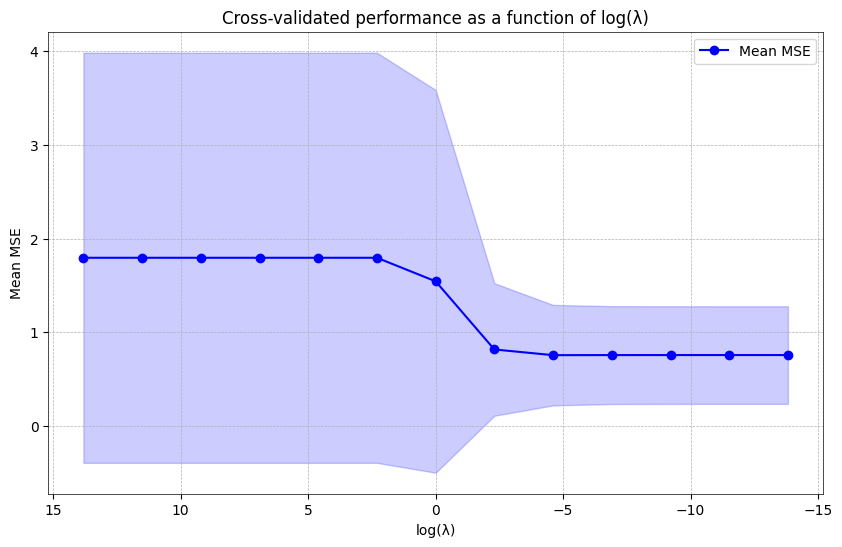

In [ ]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np

# Setting seed for reproducibility
np.random.seed(2021)

# Using ElasticNetCV for 10-fold cross-validation
# l1_ratio is set to 0.5 as an example to represent ElasticNet, adjust it as per your requirements
alphas = np.logspace(-6, 6, 13)
enet_cv = ElasticNetCV(l1_ratio=0.5, alphas=alphas, cv=10)
enet_cv.fit(X_train, y_train)

# Extracting the best alpha and its mean squared error
best_alpha = enet_cv.alpha_
mse_scores = -cross_val_score(ElasticNet(alpha=best_alpha, l1_ratio=0.5), X_train, y_train, cv=10, scoring='neg_mean_squared_error')
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print(f"Best alpha: {best_alpha}")
print(f"Mean MSE for best alpha: {mean_mse}")
print(f"Standard deviation of MSE for best alpha: {std_mse}")

# Since ElasticNetCV does not have the store_cv_values option like RidgeCV,
# we will loop through the alphas and compute cross-validated MSE for each alpha
mean_mse_scores = []
std_mse_scores = []

for alpha in alphas:
    mse_scores = -cross_val_score(ElasticNet(alpha=alpha, l1_ratio=0.5), X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    mean_mse_scores.append(mse_scores.mean())
    std_mse_scores.append(mse_scores.std())

# Convert to arrays for array operations
mean_mse_scores = np.array(mean_mse_scores)
std_mse_scores = np.array(std_mse_scores)

# Define upper and lower bounds for the point range plot
cv_lo = mean_mse_scores - std_mse_scores
cv_up = mean_mse_scores + std_mse_scores
log_alphas = np.log(alphas)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(log_alphas, mean_mse_scores, marker='o', color='blue', label='Mean MSE')
plt.fill_between(log_alphas, cv_lo, cv_up, color='blue', alpha=0.2)
plt.gca().invert_xaxis()  # Typically we plot largest to smallest values of log(λ)
plt.xlabel('log(λ)')
plt.ylabel('Mean MSE')
plt.title('Cross-validated performance as a function of log(λ)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



RSS(yhat): 99.24386487246483
RSS(ybar): 99.27692241958965


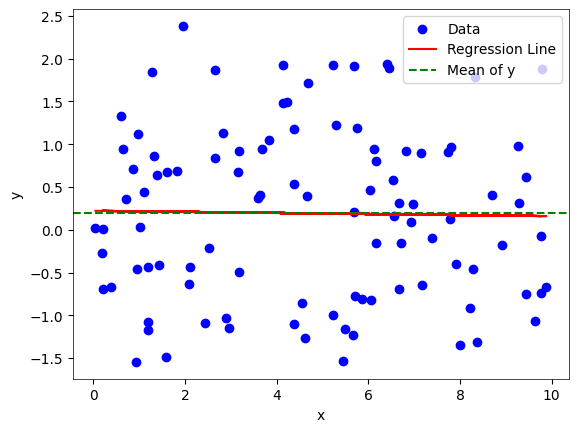

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generating random data
np.random.seed(0)  # for reproducibility
x = np.random.rand(100, 1) * 10  # random values between 0 and 10
y = np.random.randn(100, 1)  # random noise

# Fit a simple linear regression model
reg = LinearRegression().fit(x, y)
yhat = reg.predict(x)

# Calculate RSS for model predictions (yhat) and mean of y (ybar)
rss_yhat = np.sum((y - yhat)**2)
rss_ybar = np.sum((y - np.mean(y))**2)

print(f"RSS(yhat): {rss_yhat}")
print(f"RSS(ybar): {rss_ybar}")

# Visualize the data, regression line, and mean of y
plt.scatter(x, y, color='blue', label='Data')
plt.plot(x, yhat, color='red', label='Regression Line')
plt.axhline(y=np.mean(y), color='green', linestyle='--', label='Mean of y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Correlation between x1 and x2: 1.0000


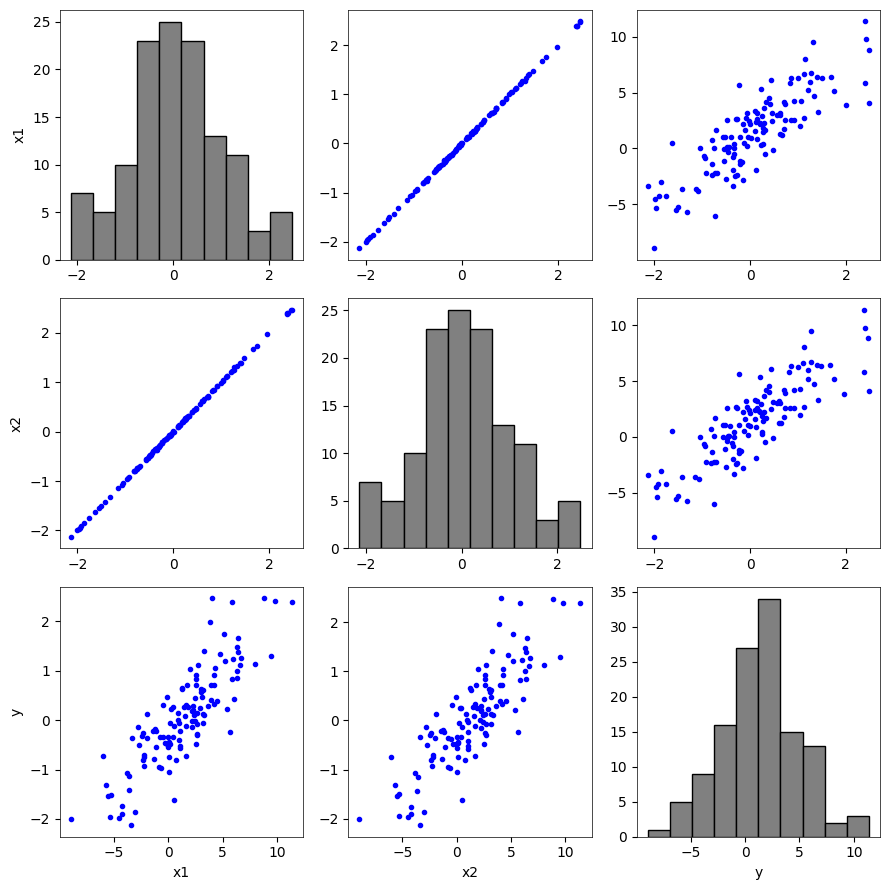

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(10)

# Generate Data
n = 125
x1 = np.random.randn(n)
x2 = x1 + 0.01 * np.random.randn(n)
correlation = np.corrcoef(x1, x2)[0, 1]
print(f"Correlation between x1 and x2: {correlation:.4f}")

y = 1 + 1*x1 + 2*x2 + 2*np.random.randn(n)

# Pairs Plot
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

# Plotting x1 vs. x1, x2, y
axs[0, 0].hist(x1, bins=10, color='gray', edgecolor='black')
axs[0, 1].scatter(x1, x2, marker='.', color='blue')
axs[0, 2].scatter(x1, y, marker='.', color='blue')

# Plotting x2 vs. x1, x2, y
axs[1, 0].scatter(x2, x1, marker='.', color='blue')
axs[1, 1].hist(x2, bins=10, color='gray', edgecolor='black')
axs[1, 2].scatter(x2, y, marker='.', color='blue')

# Plotting y vs. x1, x2, y
axs[2, 0].scatter(y, x1, marker='.', color='blue')
axs[2, 1].scatter(y, x2, marker='.', color='blue')
axs[2, 2].hist(y, bins=10, color='gray', edgecolor='black')

# Setting axis labels
for i, label in enumerate(['x1', 'x2', 'y']):
    axs[i, 0].set_ylabel(label)
    axs[2, i].set_xlabel(label)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.06134463956312, tolerance: 0.18566574305877656
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.32255005739592, tolerance: 0.18566574305877656
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.86633490115247, tolerance: 0.18566574305877656
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Conver

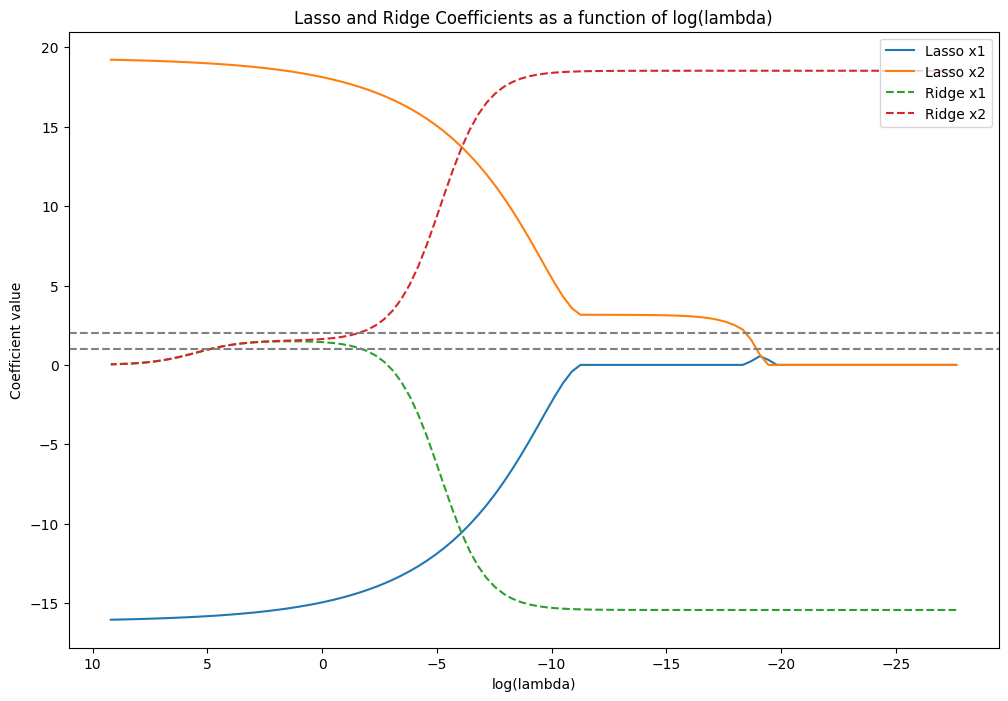

,True Coefficients,OLS,Ridge,Lasso
Intercept,1,1.214651,1.215677,1.222079
x1,1,18.528651,2.461695,2.974770
x2,2,-15.436997,0.613098,0.000000


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, lasso_path
import pandas as pd

# Generate data (as before)
np.random.seed(10)
n = 125
x1 = np.random.randn(n)
x2 = x1 + 0.01 * np.random.randn(n)
y = 1 + 1*x1 + 2*x2 + 2*np.random.randn(n)

X = np.column_stack((x1, x2))

# Lasso paths
alphas = np.logspace(-12, 4, 100)
_, lasso_coefs, _ = lasso_path(X, y, alphas=alphas)

# Manually compute Ridge path
ridge_coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    ridge_coefs.append([ridge.intercept_] + list(ridge.coef_))
ridge_coefs = np.array(ridge_coefs).T

# OLS Regression
ols = LinearRegression().fit(X, y)
ols_coefs = np.array([ols.intercept_, ols.coef_[0], ols.coef_[1]])

# Ridge and Lasso at best lambda (using alpha with minimum MSE for simplicity)
ridge_best = Ridge(alpha=0.1).fit(X, y)
ridge_coefs_best = np.array([ridge_best.intercept_, ridge_best.coef_[0], ridge_best.coef_[1]])

lasso_best = Lasso(alpha=0.1).fit(X, y)
lasso_coefs_best = np.array([lasso_best.intercept_, lasso_best.coef_[0], lasso_best.coef_[1]])

# Plot
plt.figure(figsize=(12, 8))
plt.plot(np.log(alphas), lasso_coefs[1, :], label="Lasso x1")
plt.plot(np.log(alphas), lasso_coefs[0, :], label="Lasso x2")
plt.plot(np.log(alphas), ridge_coefs[2, :], '--', label="Ridge x1")
plt.plot(np.log(alphas), ridge_coefs[1, :], '--', label="Ridge x2")
plt.axhline(1, color='grey', linestyle='--')  # True coefficient for x1
plt.axhline(2, color='grey', linestyle='--')  # True coefficient for x2
plt.xlabel("log(lambda)")
plt.ylabel("Coefficient value")
plt.legend()
plt.title("Lasso and Ridge Coefficients as a function of log(lambda)")
plt.gca().invert_xaxis()
plt.show()

# Table
df = pd.DataFrame({
    "True Coefficients": [1, 1, 2],
    "OLS": ols_coefs,
    "Ridge": ridge_coefs_best,
    "Lasso": lasso_coefs_best
}, index=["Intercept", "x1", "x2"])

df